### **Loading libraries**


In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense, RandomFlip, RandomRotation, RandomZoom, Input, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# **Data Preparation and Pre-processing**

## **Data exploration (EDA)**


**Class counts**


In [2]:
train_dir = "FER/train"
test_dir = "FER/test"
emotions = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Count images per class
def count_images(base_dir):
    counts = {}
    for emotion in emotions:
        path = base_dir + "/" + emotion
        counts[emotion] = len(os.listdir(path))
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

In [3]:
train_counts

{'Angry': 3995,
 'Disgust': 436,
 'Fear': 4097,
 'Happy': 7215,
 'Neutral': 4965,
 'Sad': 4830,
 'Surprise': 3171}

In [4]:
test_counts

{'Angry': 958,
 'Disgust': 111,
 'Fear': 1024,
 'Happy': 1774,
 'Neutral': 1233,
 'Sad': 1247,
 'Surprise': 831}

**Class distribution visualization**


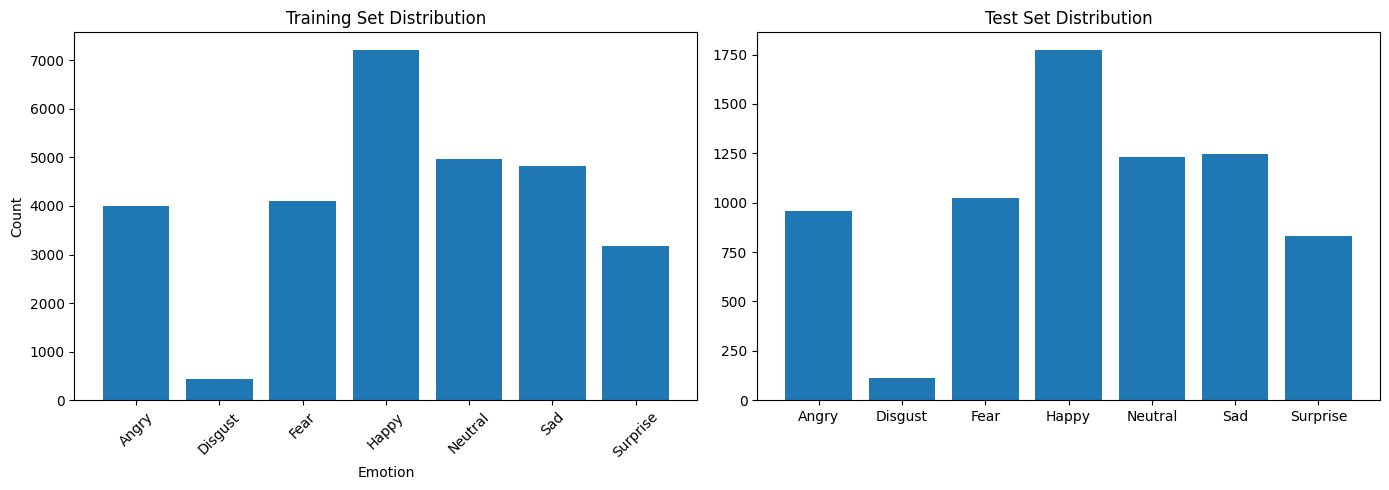

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(train_counts.keys(), train_counts.values())
axes[0].set_title('Training Set Distribution')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(test_counts.keys(), test_counts.values())
axes[1].set_title('Test Set Distribution')
plt.tight_layout()
plt.show()

In [6]:
print("Imbalance Ratio: ")
for emotion in emotions:
    ratio = train_counts[emotion] / sum(train_counts.values()) * 100
    print(f"{emotion}: {ratio:.2f}%")

Imbalance Ratio: 
Angry: 13.92%
Disgust: 1.52%
Fear: 14.27%
Happy: 25.13%
Neutral: 17.29%
Sad: 16.82%
Surprise: 11.05%


**Analyze image dimensions and properties**


In [7]:
from PIL import Image
import cv2
from collections import Counter

In [8]:
def analyze_image_properties(base_dir, sample_per_class=None):
    results = {
        'dimensions': [],
        'color_modes': [],
        'file_sizes': [],
        'emotions': [],
        'corrupted_files': [],
        'file_paths': []
    }
    
    for emotion in emotions:
        emotion_path = base_dir + "/" + emotion.lower()
        files = os.listdir(emotion_path)
        
        if sample_per_class:
            files = files[:sample_per_class]
        
        print(f"Analyzing {emotion}: {len(files)} images...")
        
        for file in files:
            img_path = emotion_path + "/" + file
            
            try:
                img = Image.open(img_path)
                
                # check image size (width & length)
                results['dimensions'].append(img.size)

                # check image color channel
                results['color_modes'].append(img.mode)
                
                results['file_sizes'].append(os.path.getsize(img_path))
                results['emotions'].append(emotion)
                results['file_paths'].append(img_path)
                
            except Exception as e:
                results['corrupted_files'].append({
                    'path': img_path,
                    'emotion': emotion,
                    'error': str(e)
                })
                print(f"Corrupted: {file} - {e}")
    
    return results

In [9]:
print("TRAINING SET RESULTS")
train_properties = analyze_image_properties(train_dir)
print("Corrupted Files:", len(train_properties['corrupted_files']))

TRAINING SET RESULTS
Analyzing Angry: 3995 images...
Analyzing Disgust: 436 images...
Analyzing Fear: 4097 images...
Analyzing Happy: 7215 images...
Analyzing Neutral: 4965 images...
Analyzing Sad: 4830 images...
Analyzing Surprise: 3171 images...
Corrupted Files: 0


In [10]:
print("TEST SET RESULTS")
test_properties = analyze_image_properties(test_dir)
print("Corrupted Files:", len(test_properties['corrupted_files']))

TEST SET RESULTS
Analyzing Angry: 958 images...
Analyzing Disgust: 111 images...
Analyzing Fear: 1024 images...
Analyzing Happy: 1774 images...
Analyzing Neutral: 1233 images...
Analyzing Sad: 1247 images...
Analyzing Surprise: 831 images...
Corrupted Files: 0


In [11]:
# Dimension
train_dims = Counter(train_properties['dimensions'])
test_dims = Counter(test_properties['dimensions'])

# Colour channel
train_modes = Counter(train_properties['color_modes'])
test_modes = Counter(test_properties['color_modes'])

# image file size
train_sizes_kb = np.array(train_properties['file_sizes']) / 1024
test_sizes_kb = np.array(test_properties['file_sizes']) / 1024

In [12]:
print("\nTraining set unique dimensions:")
for dim, count in train_dims.most_common():
    print(f"  {dim[0]}x{dim[1]}: {count} images ({count/len(train_properties['dimensions'])*100:.2f}%)")



Training set unique dimensions:
  48x48: 28709 images (100.00%)


In [13]:
print("\nTest set unique dimensions:")
for dim, count in test_dims.most_common():
    print(f"  {dim[0]}x{dim[1]}: {count} images ({count/len(test_properties['dimensions'])*100:.2f}%)")



Test set unique dimensions:
  48x48: 7178 images (100.00%)


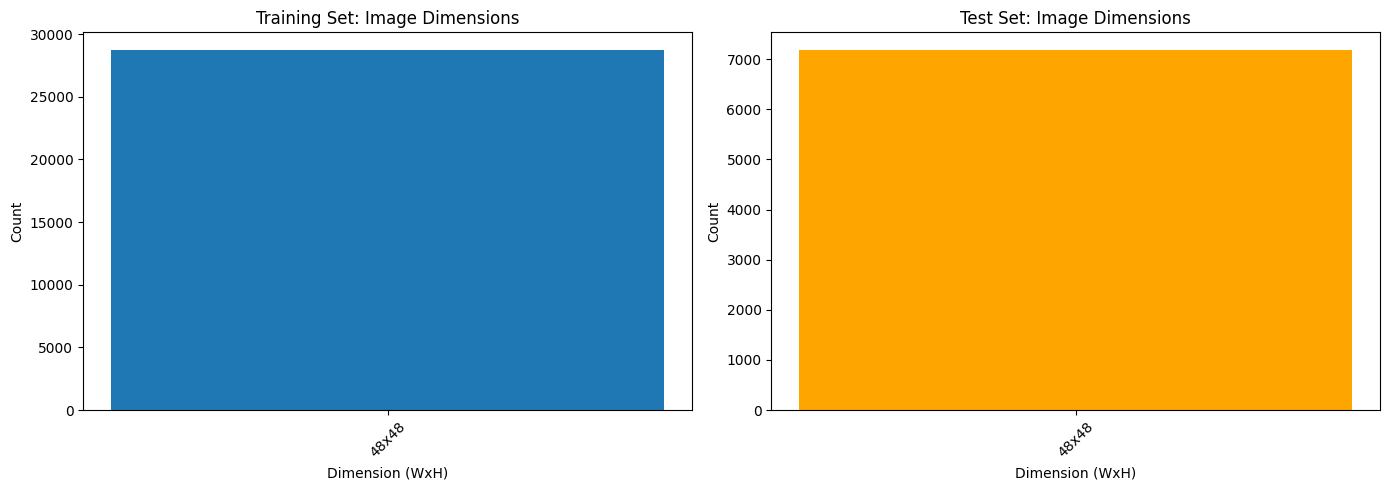

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

dim_labels_train = [f"{d[0]}x{d[1]}" for d in train_dims.keys()]
dim_counts_train = list(train_dims.values())
axes[0].bar(dim_labels_train, dim_counts_train)
axes[0].set_title('Training Set: Image Dimensions')
axes[0].set_xlabel('Dimension (WxH)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

dim_labels_test = [f"{d[0]}x{d[1]}" for d in test_dims.keys()]
dim_counts_test = list(test_dims.values())
axes[1].bar(dim_labels_test, dim_counts_test, color='orange')
axes[1].set_title('Test Set: Image Dimensions')
axes[1].set_xlabel('Dimension (WxH)')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('image_dimensions.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
print("\nTraining set color modes:")
for mode, count in train_modes.items():
    mode_name = "Grayscale" if mode == 'L' else "RGB" if mode == 'RGB' else mode
    print(f"  {mode_name} ({mode}): {count} images ({count/len(train_properties['color_modes'])*100:.2f}%)")



Training set color modes:
  Grayscale (L): 28709 images (100.00%)


In [16]:
print("\nTest set color modes:")
for mode, count in test_modes.items():
    mode_name = "Grayscale" if mode == 'L' else "RGB" if mode == 'RGB' else mode
    print(f"  {mode_name} ({mode}): {count} images ({count/len(test_properties['color_modes'])*100:.2f}%)")


Test set color modes:
  Grayscale (L): 7178 images (100.00%)


In [17]:
print("Training set file sizes (KB):")
print(f"  Mean: {np.mean(train_sizes_kb):.2f} KB")
print(f"  Median: {np.median(train_sizes_kb):.2f} KB")
print(f"  Std Dev: {np.std(train_sizes_kb):.2f} KB")
print(f"  Min: {np.min(train_sizes_kb):.2f} KB")
print(f"  Max: {np.max(train_sizes_kb):.2f} KB")

Training set file sizes (KB):
  Mean: 1.54 KB
  Median: 1.54 KB
  Std Dev: 0.16 KB
  Min: 0.35 KB
  Max: 2.34 KB


In [18]:
print("Test set file sizes (KB):")
print(f"  Mean: {np.mean(test_sizes_kb):.2f} KB")
print(f"  Median: {np.median(test_sizes_kb):.2f} KB")
print(f"  Min: {np.min(test_sizes_kb):.2f} KB")
print(f"  Max: {np.max(test_sizes_kb):.2f} KB")

Test set file sizes (KB):
  Mean: 1.54 KB
  Median: 1.54 KB
  Min: 0.35 KB
  Max: 2.42 KB


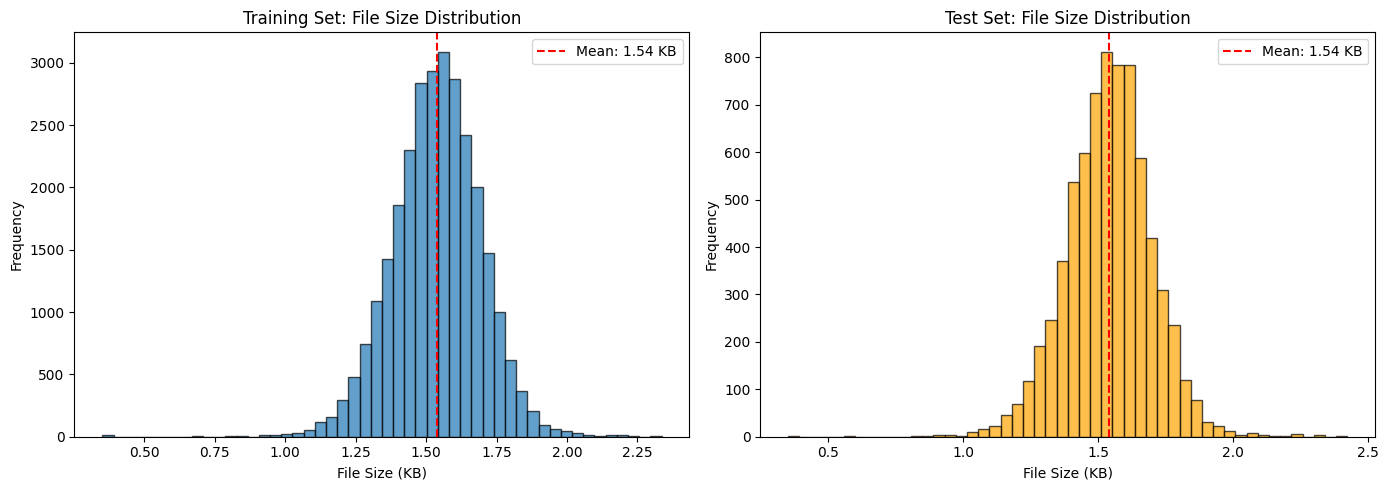

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(train_sizes_kb, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Training Set: File Size Distribution')
axes[0].set_xlabel('File Size (KB)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(train_sizes_kb), color='red', linestyle='--', label=f'Mean: {np.mean(train_sizes_kb):.2f} KB')
axes[0].legend()

axes[1].hist(test_sizes_kb, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Test Set: File Size Distribution')
axes[1].set_xlabel('File Size (KB)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(test_sizes_kb), color='red', linestyle='--', label=f'Mean: {np.mean(test_sizes_kb):.2f} KB')
axes[1].legend()

plt.tight_layout()
plt.savefig('file_sizes.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
def analyze_pixel_intensity(base_dir, sample_size=500):
    intensities = []
    
    for emotion in emotions:
        emotion_path = os.path.join(base_dir, emotion)
        files = os.listdir(emotion_path)[:sample_size//len(emotions)]
        
        for file in files:
            img_path = os.path.join(emotion_path, file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    intensities.extend(img.flatten())
            except:
                continue
    
    return np.array(intensities)

train_intensities = analyze_pixel_intensity(train_dir, sample_size=500)

In [21]:
print(f"Pixel intensity statistics:")
print(f"  Mean: {np.mean(train_intensities):.2f}")
print(f"  Median: {np.median(train_intensities):.2f}")
print(f"  Std Dev: {np.std(train_intensities):.2f}")
print(f"  Min: {np.min(train_intensities)}")
print(f"  Max: {np.max(train_intensities)}")

Pixel intensity statistics:
  Mean: 130.76
  Median: 135.00
  Std Dev: 64.24
  Min: 0
  Max: 255


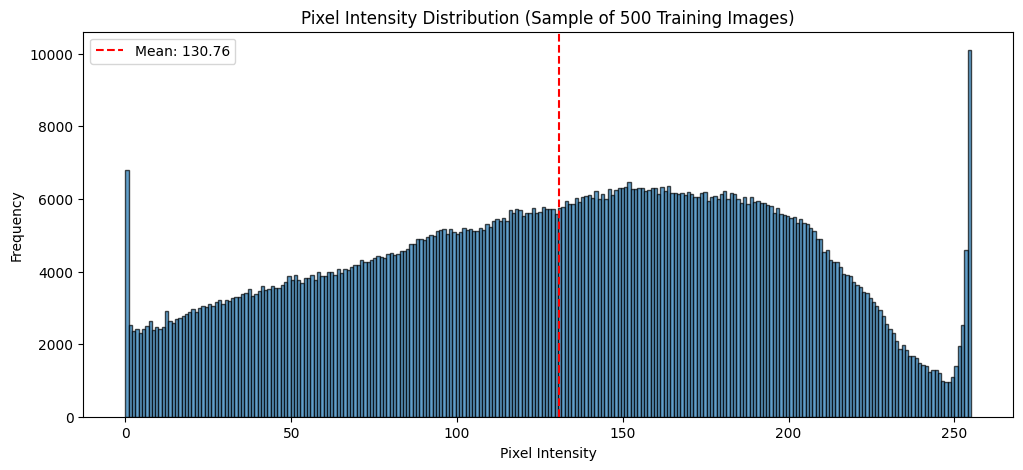

In [22]:
plt.figure(figsize=(12, 5))
plt.hist(train_intensities, bins=256, range=(0, 255), edgecolor='black', alpha=0.7)
plt.title('Pixel Intensity Distribution (Sample of 500 Training Images)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.axvline(np.mean(train_intensities), color='red', linestyle='--', label=f'Mean: {np.mean(train_intensities):.2f}')
plt.legend()
plt.savefig('pixel_intensity.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
def intensity_by_emotion(base_dir, sample_per_class=100):
    emotion_intensities = {emotion: [] for emotion in emotions}

    for emotion in emotions:
        emotion_path = base_dir + "/" + emotion.lower()
        files = os.listdir(emotion_path)[:sample_per_class]
        
        for file in files:
            img_path = emotion_path + "/" + file
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    emotion_intensities[emotion].append(np.mean(img))
            except:
                continue
    
    return emotion_intensities

emotion_intensity_data = intensity_by_emotion(train_dir, sample_per_class=200)

for emotion in emotions:
    mean_intensity = np.mean(emotion_intensity_data[emotion])
    std_intensity = np.std(emotion_intensity_data[emotion])
    print(f"{emotion.capitalize():10s}: Mean = {mean_intensity:.2f}, Std = {std_intensity:.2f}")

Angry     : Mean = 128.79, Std = 32.50
Disgust   : Mean = 138.09, Std = 31.12
Fear      : Mean = 135.52, Std = 34.23
Happy     : Mean = 128.13, Std = 30.77
Neutral   : Mean = 118.95, Std = 31.81
Sad       : Mean = 118.09, Std = 33.32
Surprise  : Mean = 145.59, Std = 34.97


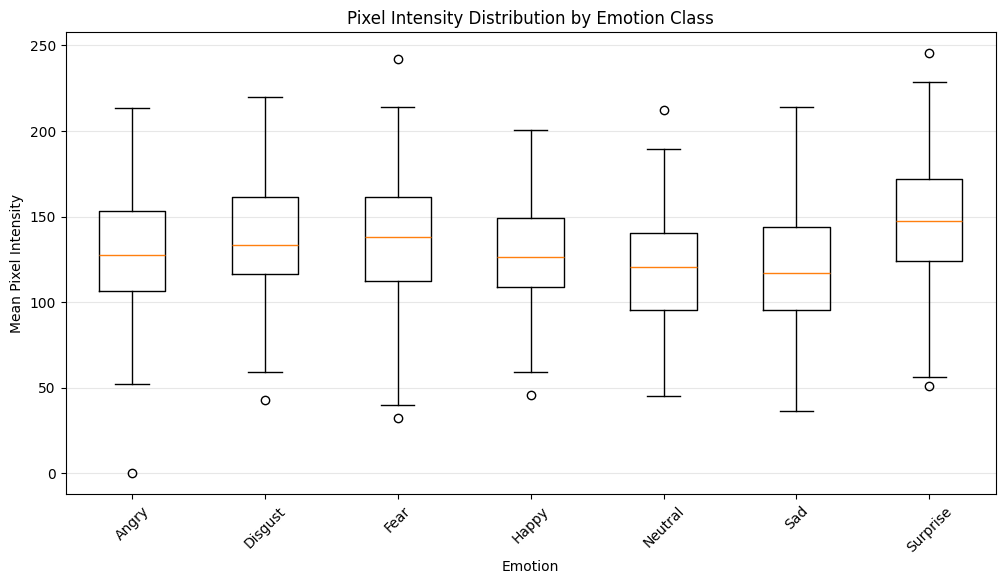

In [24]:
plt.figure(figsize=(12, 6))
plt.boxplot([emotion_intensity_data[e] for e in emotions], tick_labels=emotions)
plt.title('Pixel Intensity Distribution by Emotion Class')
plt.ylabel('Mean Pixel Intensity')
plt.xlabel('Emotion')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.savefig('intensity_by_emotion.png', dpi=300, bbox_inches='tight')
plt.show()

## **Detecting and removing dirty data**


In [25]:
import shutil

In [26]:
# detect images that are too dark or too bright
def detect_extreme_intensity_images(base_dir, min_threshold=20, max_threshold=235):
    extreme_images = []
    
    for emotion in emotions:
        emotion_path = base_dir + "/" + emotion.lower()
        files = os.listdir(emotion_path)
        
        for file in files:
            img_path = emotion_path + "/" + file
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is not None:
                    mean_intensity = np.mean(img)
                    
                    if mean_intensity < min_threshold:
                        extreme_images.append({
                            'path': img_path,
                            'emotion': emotion,
                            'filename': file,
                            'mean_intensity': mean_intensity,
                            'issue': 'too_dark'
                        })
                    elif mean_intensity > max_threshold:
                        extreme_images.append({
                            'path': img_path,
                            'emotion': emotion,
                            'filename': file,
                            'mean_intensity': mean_intensity,
                            'issue': 'too_bright'
                        })
            except Exception as e:
                print(f"  Error reading {file}: {e}")
    
    return extreme_images

print("Analyzing training set...")
train_extreme = detect_extreme_intensity_images(train_dir, min_threshold=20, max_threshold=235)
print("Analyzing test set...")
test_extreme = detect_extreme_intensity_images(test_dir, min_threshold=20, max_threshold=235)

Analyzing training set...
Analyzing test set...


In [27]:
print("Training set by emotion:")
for emotion in emotions:
    too_dark = sum(1 for img in train_extreme if img['emotion'] == emotion and img['issue'] == 'too_dark')
    too_bright = sum(1 for img in train_extreme if img['emotion'] == emotion and img['issue'] == 'too_bright')
    if too_dark > 0 or too_bright > 0:
        print(f"  {emotion.capitalize():10s}: {too_dark} too dark, {too_bright} too bright")

Training set by emotion:
  Angry     : 10 too dark, 3 too bright
  Disgust   : 0 too dark, 1 too bright
  Fear      : 0 too dark, 3 too bright
  Happy     : 2 too dark, 5 too bright
  Neutral   : 3 too dark, 3 too bright
  Sad       : 3 too dark, 0 too bright
  Surprise  : 1 too dark, 6 too bright


In [28]:
print("Test set by emotion:")
for emotion in emotions:
    too_dark = sum(1 for img in test_extreme if img['emotion'] == emotion and img['issue'] == 'too_dark')
    too_bright = sum(1 for img in test_extreme if img['emotion'] == emotion and img['issue'] == 'too_bright')
    if too_dark > 0 or too_bright > 0:
        print(f"  {emotion.capitalize():10s}: {too_dark} too dark, {too_bright} too bright")

Test set by emotion:
  Angry     : 1 too dark, 1 too bright
  Fear      : 0 too dark, 1 too bright
  Happy     : 2 too dark, 0 too bright
  Neutral   : 1 too dark, 0 too bright
  Sad       : 0 too dark, 2 too bright
  Surprise  : 1 too dark, 1 too bright


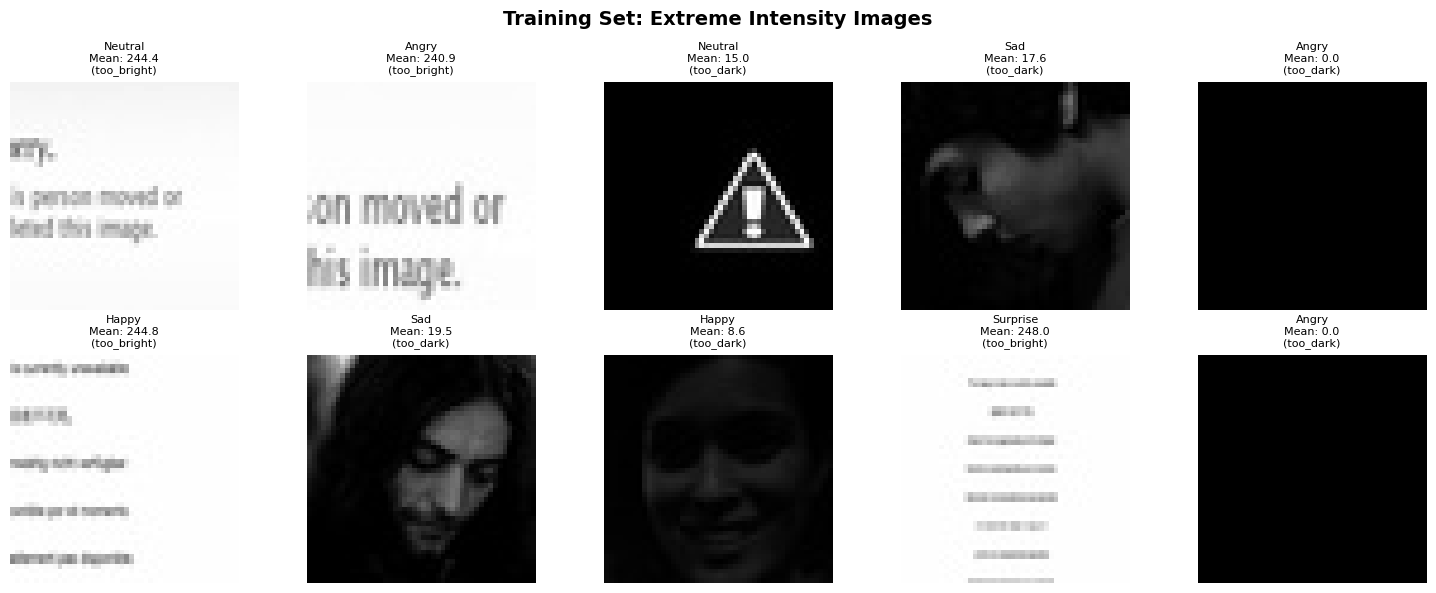

In [29]:
def visualize_extreme_images(extreme_images, n_samples=10, title="Extreme Intensity Images"):
    if len(extreme_images) == 0:
        print("No extreme images to display")
        return
    
    sample_size = min(n_samples, len(extreme_images))
    samples = np.random.choice(len(extreme_images), sample_size, replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, idx in enumerate(samples):
        img_data = extreme_images[idx]
        img = cv2.imread(img_data['path'], cv2.IMREAD_GRAYSCALE)
        
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=255)
        axes[i].set_title(f"{img_data['emotion']}\nMean: {img_data['mean_intensity']:.1f}\n({img_data['issue']})", fontsize=8)
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('extreme_intensity_samples.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize samples
if len(train_extreme) > 0:
    visualize_extreme_images(train_extreme, n_samples=10, title="Training Set: Extreme Intensity Images")

In [30]:
def quarantine_extreme_images(base_dir, extreme_images, quarantine_dir='FER/quarantine_extreme'):
    os.makedirs(quarantine_dir, exist_ok=True)
    os.makedirs((quarantine_dir + '/' + 'too_dark'), exist_ok=True)
    os.makedirs((quarantine_dir + '/' + 'too_bright'), exist_ok=True)
    
    moved_count = 0
    
    for img_data in extreme_images:
        src = img_data['path']
        dst_folder = quarantine_dir + '/' + str(img_data['issue'])
        dst = dst_folder + "/" + f"{img_data['emotion']}_{img_data['filename']}"
        
        try:
            shutil.move(src, dst)
            moved_count += 1
        except Exception as e:
            print(f"Error moving {src}: {e}")
    
    print(f"\nMoved {moved_count} images to quarantine folder: {quarantine_dir}")
    return moved_count

# Quarantine extreme images
print("\n" + "=" * 50)
print("QUARANTINING EXTREME IMAGES")
print("=" * 50)

# Uncomment to execute:
train_moved = quarantine_extreme_images(train_dir, train_extreme, 'FER/quarantine_extreme_train')
test_moved = quarantine_extreme_images(test_dir, test_extreme, 'FER/quarantine_extreme_test')



QUARANTINING EXTREME IMAGES

Moved 40 images to quarantine folder: FER/quarantine_extreme_train

Moved 10 images to quarantine folder: FER/quarantine_extreme_test
